# Analyse Statistiques des logs

Ce programme permet d'afficher sur un graphique la répartition du nombre de périodes relevées entre 2 impulsions nucléaires à l'aide des logs enregistrées

Amplitude (A) : -7.969338411904867e-05
Coefficient de décroissance (a) : 5.411453749425601


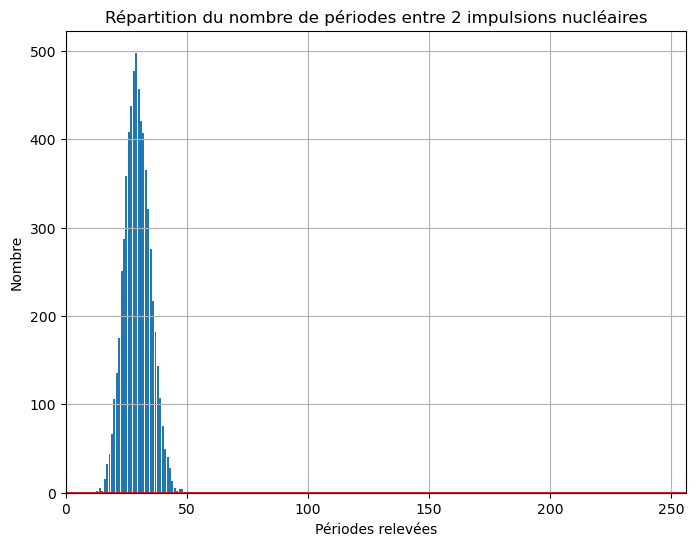

L'amplitude de l'exponentielle A vaut  -7.969338411904867e-05
Le coefficient de décroissance a vaut  270572.68747128005


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import csv
from collections import defaultdict

# Lecture des données depuis le fichier putty.csv généré par le terminal et regroupement des différents relevés
data = defaultdict(list)
with open('putty.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=';')
    for row in csvreader:
        key = int(row[0])
        value = int(row[1])
        data[key].append(value)

# Préparation des données pour le tracé
keys = list(data.keys())
values = [sum(data[key]) for key in keys]


# Définition de la fonction exponentielle à ajuster
def exponential_function(x, a, b):
    return a * np.exp(-b * x)

# Ajustement de la courbe exponentielle aux données
popt, pcov = curve_fit(exponential_function, keys, values)

# Récupération des paramètres optimaux (a et b)
a_optimal, b_optimal = popt

# Affichage du coefficient de décroissance
print("Amplitude (A) :", a_optimal)
print("Coefficient de décroissance (a) :", b_optimal)


# Tracé du graphique à barres et configuration de sa taille
plt.figure(figsize=(8,6))
plt.bar(keys, values)

# Ajouter le tracé d'une courbe exponentielle décroissante
x_exp = np.linspace(0, 256, 1000)  # Générer des points pour l'axe x de 0 à 256
y_exp = a_optimal * np.exp(-b_optimal * x_exp)  # Calculer les valeurs de la fonction exponentielle décroissante
plt.plot(x_exp, y_exp, color='red', linewidth=2, label=r'$e^{-ax}$')  # Utilisation de LaTeX pour l'étiquette

# Configuration du zoom
plt.xlim(0, 256)

# Configuration générale du graphique
plt.title('Répartition du nombre de périodes entre 2 impulsions nucléaires')
plt.xlabel('Périodes relevées')
plt.ylabel('Nombre')
plt.grid(True)


plt.show()
print("L'amplitude de l'exponentielle A vaut ", a_optimal)
print("Le coefficient de décroissance a vaut ", b_optimal*50000)

# Application prototype fonctionnelle

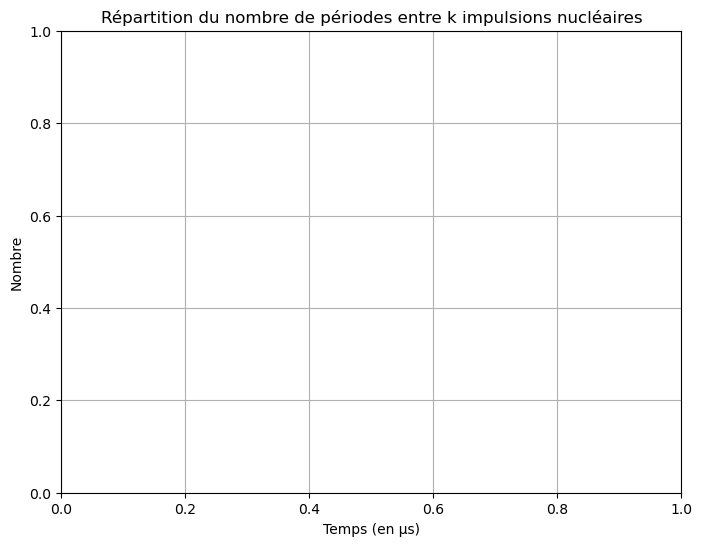

In [12]:
from modules.fileManaging import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import csv
from collections import defaultdict
import tkinter
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import *
import math
from scipy.stats import poisson

# Screen
analysis = tkinter.Tk() # Définition d'un écran
analysis.geometry("1280x720") # Définition de la taille de l'écran
analysis.title("Desintegrations Nucleaires") # Définition du titre de l'écran

# Label
l1 = Label(text="Distribution de Poisson/Erlang", font=("Arial", 16, "bold")) # Définition du titre
l1.pack() # Affichage du label

# Affichage d'un graphique vide initial
fig, ax = plt.subplots(figsize=(8, 6)) # Définition de sa taille
ax.set_title('Répartition du nombre de périodes entre k impulsions nucléaires') # Titre
ax.set_xlabel('Temps (en µs)') # Abscisse
ax.set_ylabel('Nombre') # Ordonnée
ax.grid(True) # Affichage d'une grille

# Définition du canvas initial
canvas = FigureCanvasTkAgg(fig, master=analysis)
canvas.draw()
canvas.get_tk_widget().pack()

data = defaultdict(list) # Liste de données pour la lecture du fichier csv
selected_value = tkinter.IntVar()  # Variable k
selected_value.set(1)

# def
def exit():
    quit()  # Pour fermer l'application

def open_file():
    global data # Définition globale des données pour son utilisation par d'autres fonctions
    filepath = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")]) # Ouverture d'un explorateur de fichier pour selectionner un fichier csv à lire
    if not filepath:
        return # Termine la fonction ici si aucun fichier n'est selectionné
    data = defaultdict(list) 
    with open(filepath, 'r') as csvfile: # Ouverture du fichier spécifié en temps que csv
        csvreader = csv.reader(csvfile, delimiter=';') # Définition du séparateur de données
        for row in csvreader: # Lecture des données
            key = int(row[0]) # Lecture des canaux
            value = int(row[1]) # Lecture des valeurs relevées
            data[key].append(value) # Affectation des données dans le tableau data
    plot_data(data) # Appel de la fonction d'affichage des données

def plot_data(data):
    keys = list(data.keys()) # Echelle horizontale (canaux)
    values = [sum(data[key]) for key in keys] # On somme les valeurs des canaux entre elles pour les combiner
    
    # On adapte les canaux au bon temps (On suppose que le clock utilisée est de 20µs)
    scaled_keys = [key * 20 for key in keys]
    
    # On filtre les valeurs pour savoir jusqu'où elles ne sont pas nulles
    non_zero_keys = [key for key, value in zip(keys, values) if value != 0]
    
    if not non_zero_keys:
        return  # Si toutes les valeurs sont nulles, on ne trace rien

    # On défini l'intervalle où les valeurs sont non nulles pour zoomer
    x_min = min(non_zero_keys)
    x_max = max(non_zero_keys)

    ax.clear()  # Effacer le graphique précédent
    ax.bar(keys, values) # Tracer en graphique à barre des valeurs
    ax.set_xlim(x_min, x_max) # On utilise l'intervalle défini pour zoomer
    ax.set_title(f'Répartition du nombre de périodes entre k impulsions nucléaires')
    ax.set_xlabel('Temps (en µs)')
    ax.set_ylabel('Itérations')
    ax.grid(True) # Affichage de la grille

    canvas.draw()  # On met à jour le canvas pour afficher le graphique
    
def erlang_pdf(x, A, k, lambd): # Definition de la formule de la distribution d'Erlang
    return A * (lambd ** k * x ** (k - 1) * np.exp(-lambd * x)) / math.factorial(k - 1)

def add_erlang_fit(): # Fonction pour l'affichage de l'exponentielle correspondant à la distribution d'Erlang
    k_value = selected_value.get() # On récupère la valeur de k dans le menu déroulant
    keys = list(data.keys())
    values = [sum(data[key]) for key in keys]
    
    # Appliquer le facteur x20 à l'échelle de temps
    scaled_keys = [key * 1 for key in keys]
    
    # Ajustement de la courbe d'Erlang aux données
    popt, _ = curve_fit(lambda x, A, lambd: erlang_pdf(x, A, k_value, lambd), scaled_keys, values, p0=[max(values), 0.1])
    
    # Récupération des paramètres optimaux (lambd seulement, k est connu)
    A_optimal, lambd_optimal = popt
    # Générer des points pour l'axe x
    x_data = np.linspace(min(scaled_keys), max(scaled_keys), 1000)

    # Calculer les valeurs de la fonction d'Erlang
    y_data = erlang_pdf(x_data, A_optimal, k_value, lambd_optimal)
    
    # Tracé des données expérimentales et de l'ajustement de la courbe d'Erlang
    ax.plot(x_data, y_data, color='red', linewidth=2, label=f'Distribution d\'Erlang (k={k_value}, λ={lambd_optimal*50000:.2f}, A={A_optimal})')
    ax.legend()
    canvas.draw()  # Redessiner le canvas

    
def gauss(x, a, x0, sigma): #definition de la formule generale d'une Gausienne
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def add_gaussian_fit():
    if not data:
        return
    
    keys = np.array(list(data.keys())) # Echelle horizontale (canaux)
    values = np.array([sum(data[key]) for key in keys]) # On somme les valeurs des canaux entre elles pour les combiner

    mean = sum(keys * values) / sum(values)
    sigma = np.sqrt(sum(values * (keys - mean) ** 2) / sum(values))

    popt, pcov = curve_fit(gauss, keys, values, p0=[max(values), mean, sigma])
    
    x_fit = np.linspace(min(keys), max(keys), 1000)
    y_fit = gauss(x_fit, *popt)
    
    ax.plot(x_fit, y_fit, color='green', label='Gaussienne ajustée')
    ax.legend()
    canvas.draw()
    
def add_poisson_fit():
    keys = np.array(list(data.keys())) # Echelle horizontale (canaux)
    values = np.array([sum(data[key]) for key in keys]) # On somme les valeurs des canaux entre elles pour les combiner

    # Estimation de la moyenne de la distribution de Poisson
    mean = sum(keys * values) / sum(values)
    
    # Génération des valeurs de la distribution de Poisson
    poisson_dist = poisson.pmf(keys, mean) * sum(values)
    
    ax.plot(keys, poisson_dist, color='blue', label='Distribution de Poisson')
    ax.legend()
    canvas.draw()


# Bouton
b1 = Button(text="Load CSV", command=(open_file)) # Bouton pour sélectionner et afficher des données
b1.place(x=60,y=100)
b2 = Button(text="Add Exponential Fit", command=(add_erlang_fit))
b2.place(x=60,y=180)

bclose = Button(text="Close Application", command=(exit)) # Bouton pour fermer l'application
bclose.place(x=60,y=220)
options = list(range(1, 10)) # Definition de la liste d'options
selected_value = tkinter.IntVar() # Declaration de la variable de selection
selected_value.set(options[0])  # Sélectionne la première option par défaut
option_menu = tkinter.OptionMenu(analysis, selected_value, *options) # Definition du menu sur le screen
option_menu.place(x=120,y=140) # Position du menu
l2 = Label(text="Facteur k") # Définition du titre
l2.place(x=60,y=145) # Affichage du label

# Bouton pour tracer la Gaussienne
button_gaussian = tkinter.Button(analysis, text="Add Gaussian Fit", command=add_gaussian_fit)
button_gaussian.place(x=60,y=260)

# Bouton pour tracer la Gaussienne
button_poisson = tkinter.Button(analysis, text="Add Poisson Fit", command=add_poisson_fit)
button_poisson.place(x=60,y=300)

############################## Fonctions du mode Erlang ##############################


# Loop
analysis.mainloop() # Pour maintenir l'application ouverte


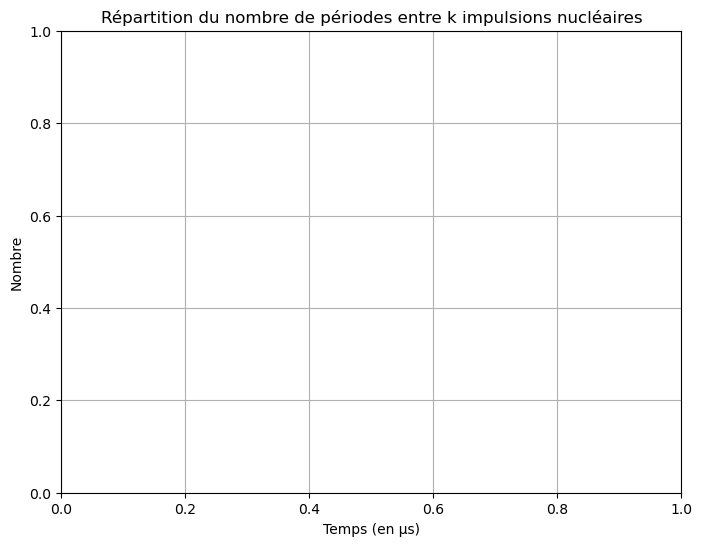

In [10]:
from modules.fileManaging import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import csv
from collections import defaultdict
import tkinter
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import *
import math
from scipy.stats import poisson

# Screen
analysis = tkinter.Tk() # Définition d'un écran
analysis.geometry("1280x720") # Définition de la taille de l'écran
analysis.title("Desintegrations Nucleaires") # Définition du titre de l'écran

# Label
l1 = Label(text="Distribution de Poisson/Erlang", font=("Arial", 16, "bold")) # Définition du titre
l1.pack() # Affichage du label

# Affichage d'un graphique vide initial
fig, ax = plt.subplots(figsize=(8, 6)) # Définition de sa taille
ax.set_title('Répartition du nombre de périodes entre k impulsions nucléaires') # Titre
ax.set_xlabel('Temps (en µs)') # Abscisse
ax.set_ylabel('Nombre') # Ordonnée
ax.grid(True) # Affichage d'une grille

# Définition du canvas initial
canvas = FigureCanvasTkAgg(fig, master=analysis)
canvas.draw()
canvas.get_tk_widget().pack()

data = defaultdict(list) # Liste de données pour la lecture du fichier csv
selected_value = tkinter.IntVar()  # Variable k
selected_value.set(1)

# def
def exit():
    quit()  # Pour fermer l'application

def open_file():
    global data # Définition globale des données pour son utilisation par d'autres fonctions
    filepath = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")]) # Ouverture d'un explorateur de fichier pour selectionner un fichier csv à lire
    if not filepath:
        return # Termine la fonction ici si aucun fichier n'est selectionné
    data = defaultdict(list) 
    with open(filepath, 'r') as csvfile: # Ouverture du fichier spécifié en temps que csv
        csvreader = csv.reader(csvfile, delimiter=';') # Définition du séparateur de données
        for row in csvreader: # Lecture des données
            key = int(row[0]) # Lecture des canaux
            value = int(row[1]) # Lecture des valeurs relevées
            data[key].append(value) # Affectation des données dans le tableau data
    plot_data(data) # Appel de la fonction d'affichage des données

def plot_data(data):
    keys = list(data.keys()) # Echelle horizontale (canaux)
    values = [sum(data[key]) for key in keys] # On somme les valeurs des canaux entre elles pour les combiner
    
    # On adapte les canaux au bon temps (On suppose que le clock utilisée est de 20µs)
    scaled_keys = [key * 20 for key in keys]
    
    # On filtre les valeurs pour savoir jusqu'où elles ne sont pas nulles
    non_zero_keys = [key for key, value in zip(keys, values) if value != 0]
    
    if not non_zero_keys:
        return  # Si toutes les valeurs sont nulles, on ne trace rien

    # On défini l'intervalle où les valeurs sont non nulles pour zoomer
    x_min = min(non_zero_keys)
    x_max = max(non_zero_keys)

    ax.clear()  # Effacer le graphique précédent
    ax.bar(keys, values) # Tracer en graphique à barre des valeurs
    ax.set_xlim(x_min, x_max) # On utilise l'intervalle défini pour zoomer
    ax.set_title(f'Répartition du nombre de périodes entre k impulsions nucléaires')
    ax.set_xlabel('Temps (en µs)')
    ax.set_ylabel('Itérations')
    ax.grid(True) # Affichage de la grille

    canvas.draw()  # On met à jour le canvas pour afficher le graphique
    
def erlang_pdf(x, A, k, lambd): # Definition de la formule de la distribution d'Erlang
    return A * (lambd ** k * x ** (k - 1) * np.exp(-lambd * x)) / math.factorial(k - 1)

def add_erlang_fit(): # Fonction pour l'affichage de l'exponentielle correspondant à la distribution d'Erlang
    k_value = selected_value.get() # On récupère la valeur de k dans le menu déroulant
    keys = list(data.keys())
    values = [sum(data[key]) for key in keys]
    
    # Appliquer le facteur x20 à l'échelle de temps
    scaled_keys = [key * 1 for key in keys]
    
    # Ajustement de la courbe d'Erlang aux données
    popt, _ = curve_fit(lambda x, A, lambd: erlang_pdf(x, A, k_value, lambd), scaled_keys, values, p0=[max(values), 0.1])
    
    # Récupération des paramètres optimaux (lambd seulement, k est connu)
    A_optimal, lambd_optimal = popt
    # Générer des points pour l'axe x
    x_data = np.linspace(min(scaled_keys), max(scaled_keys), 1000)
    
    # Calculer les valeurs de la fonction d'Erlang
    y_data = erlang_pdf(x_data, A_optimal, k_value, lambd_optimal)
    
    # Tracé des données expérimentales et de l'ajustement de la courbe d'Erlang
    ax.plot(x_data, y_data, color='red', linewidth=2, label=f'Distribution d\'Erlang (k={k_value}, λ={lambd_optimal*50000:.2f}, A={A_optimal})')
    ax.legend()
    canvas.draw()  # Redessiner le canvas

    
def gauss(x, a, x0, sigma): #definition de la formule generale d'une Gausienne
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def add_gaussian_fit():
    if not data:
        return
    
    keys = np.array(list(data.keys())) # Echelle horizontale (canaux)
    values = np.array([sum(data[key]) for key in keys]) # On somme les valeurs des canaux entre elles pour les combiner

    mean = sum(keys * values) / sum(values)
    sigma = np.sqrt(sum(values * (keys - mean) ** 2) / sum(values))

    popt, pcov = curve_fit(gauss, keys, values, p0=[max(values), mean, sigma])
    
    x_fit = np.linspace(min(keys), max(keys), 1000)
    y_fit = gauss(x_fit, *popt)
    
    ax.plot(x_fit, y_fit, color='green', label='Gaussienne ajustée')
    ax.legend()
    canvas.draw()
    
def add_poisson_fit():
    keys = np.array(list(data.keys())) # Echelle horizontale (canaux)
    values = np.array([sum(data[key]) for key in keys]) # On somme les valeurs des canaux entre elles pour les combiner

    # Estimation de la moyenne de la distribution de Poisson
    mean = sum(keys * values) / sum(values)
    
    # Génération des valeurs de la distribution de Poisson
    poisson_dist = poisson.pmf(keys, mean) * sum(values)
    
    ax.plot(keys, poisson_dist, color='blue', label='Distribution de Poisson')
    ax.legend()
    canvas.draw()


# Bouton
b1 = Button(text="Load CSV", command=(open_file)) # Bouton pour sélectionner et afficher des données
b1.place(x=60,y=100)
b2 = Button(text="Add Exponential Fit", command=(add_erlang_fit))
b2.place(x=60,y=180)

bclose = Button(text="Close Application", command=(exit)) # Bouton pour fermer l'application
bclose.place(x=60,y=220)
options = list(range(1, 10)) # Definition de la liste d'options
selected_value = tkinter.IntVar() # Declaration de la variable de selection
selected_value.set(options[0])  # Sélectionne la première option par défaut
option_menu = tkinter.OptionMenu(analysis, selected_value, *options) # Definition du menu sur le screen
option_menu.place(x=120,y=140) # Position du menu
l2 = Label(text="Facteur k") # Définition du titre
l2.place(x=60,y=145) # Affichage du label

# Bouton pour tracer la Gaussienne
button_gaussian = tkinter.Button(analysis, text="Add Gaussian Fit", command=add_gaussian_fit)
button_gaussian.place(x=60,y=260)

# Bouton pour tracer la Gaussienne
button_poisson = tkinter.Button(analysis, text="Add Poisson Fit", command=add_poisson_fit)
button_poisson.place(x=60,y=300)

############################## Fonctions du mode Erlang ##############################


# Loop
analysis.mainloop() # Pour maintenir l'application ouverte


In [12]:
def show_erlang_mode(*args):
    if modeSelect_var.get() == "Erlang":
        # Afficher les éléments spécifiques à Erlang
        option_menu.grid()
        l2.grid()
        b2.grid()
        bclose.grid()
    else:
        # Masquer les éléments spécifiques à Erlang
        option_menu.grid_remove()
        l2.grid_remove()
        b2.grid_remove()
        bclose.grid_remove()

# Attacher la fonction show_erlang_mode au changement de la variable modeSelect_var
modeSelect_var.trace_add("write", show_erlang_mode)

# Menu de selection du mode d'affichage Erlang/Poisson
modeSelect = ["Erlang", "Poisson"]
modeSelect_var = tkinter.StringVar(analysis)
modeSelect_var.set(modeSelect[0])  # Sélectionne la première option par défaut
modeSelect_menu = tkinter.OptionMenu(analysis, modeSelect_var, *modeSelect)
modeSelect_menu.place(x=58, y=60)
l2 = Label(text="Distribution de Poisson/Erlang", font=("Arial", 16, "bold")) # Définition du titre
l2.place() # Affichage du label

if modeSelect_var == "Erlang":
    # Menus
    options = list(range(1, 10)) # Definition de la liste d'options
    selected_value = tkinter.IntVar() # Declaration de la variable de selection
    selected_value.set(options[0])  # Sélectionne la première option par défaut
    option_menu = tkinter.OptionMenu(analysis, selected_value, *options) # Definition du menu sur le screen
    option_menu.place(x=120,y=140) # Position du menu
    l2 = Label(text="Facteur k") # Définition du titre
    l2.place(x=60,y=145) # Affichage du label

    # Bouton pour ajouter la courbe exponentielle
    b2 = Button(text="Add Exponential Fit", command=(add_erlang_fit))
    b2.place(x=60,y=180)

    bclose = Button(text="Close Application", command=(exit)) # Bouton pour fermer l'application
    bclose.place(x=60,y=220)

NameError: name 'modeSelect_var' is not defined

In [1]:
import threading
import serial
import csv
import time

def read_from_uart(ser, data_queue):
    while True:
        if ser.in_waiting > 0:
            data = ser.readline().decode('utf-8').rstrip()
            if data:
                data_queue.append(data)

def save_to_csv(data_queue, filename):
    with open(filename, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        while True:
            if data_queue:
                data = data_queue.pop(0)
                csvwriter.writerow([time.strftime("%Y-%m-%d %H:%M:%S"), data])
                csvfile.flush()

def process_data(data_queue):
    while True:
        if data_queue:
            data = data_queue.pop(0)
            # Traitez les données ici
            print(f"Processing: {data}")

def main():
    uart_port = 'COM3'  # Remplacez par votre port série
    baud_rate = 57600
    ser = serial.Serial(uart_port, baud_rate, timeout=1)

    data_queue = []

    threading.Thread(target=read_from_uart, args=(ser, data_queue)).start()
    threading.Thread(target=save_to_csv, args=(data_queue, 'data.csv')).start()
    #threading.Thread(target=process_data, args=(data_queue,)).start()

if __name__ == "__main__":
    main()


Exception in thread Thread-5 (read_from_uart):
Traceback (most recent call last):
  File "D:\Anaconda\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "D:\Anaconda\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\romai\AppData\Local\Temp\ipykernel_19248\176443870.py", line 8, in read_from_uart
  File "D:\Anaconda\Lib\site-packages\serial\serialwin32.py", line 259, in in_waiting
    raise SerialException("ClearCommError failed ({!r})".format(ctypes.WinError()))
serial.serialutil.SerialException: ClearCommError failed (PermissionError(13, 'Accès refusé.', None, 5))


In [16]:
!pip install pyserial

  Obtaining dependency information for pyserial from https://files.pythonhosted.org/packages/07/bc/587a445451b253b285629263eb51c2d8e9bcea4fc97826266d186f96f558/pyserial-3.5-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/90.6 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/90.6 kB ? eta -:--:--
   ------------------------------------ --- 81.9/90.6 kB 1.2 MB/s eta 0:00:01
   ---------------------------------------- 90.6/90.6 kB 1.0 MB/s eta 0:00:00
